In [1]:
import numpy as np
import cv2
import random
import pickle
import pandas as pd
import time
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn import linear_model


import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from numpy import linalg as LA

import umap
from fashion_model import FashionCNN 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


EXPERIMENT = 'fashion_mnist'
# EXPERIMENT = 'mnist'
# EXPERIMENT = 'compass'
# EXPERIMENT = 'german'

if EXPERIMENT == 'fashion_mnist':
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
all_images, all_labels = next(iter(all_loader))

# start_time = time.time()
# umap_sampling = UMAP_local_sampling(all_images)
# umap_duration = time.time() - start_time
# print("UMAP duration: ", umap_duration)

Done loading


In [2]:
from fashion_model import FashionCNN 

checkpt_file = 'pretrained/fashionCNN.pt'
print(checkpt_file)

model = FashionCNN()
model.to(device)
model.load_state_dict(torch.load(checkpt_file))

pretrained/fashionCNN.pt


<All keys matched successfully>

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])
labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

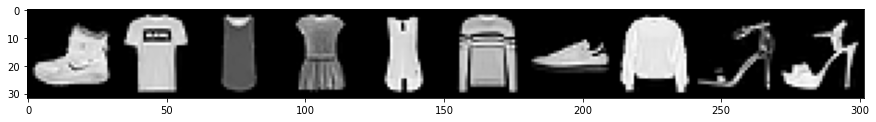

In [3]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

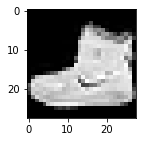

In [4]:
sample_idx = 0
ex_img = images[sample_idx]
grid = torchvision.utils.make_grid(ex_img, nrow=1)
plt.figure(figsize=(2, 2))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [171]:
class Manifold_Image_Sampler(object):
    def __init__(self, data, dim = 2, random_state = 1,
                labels = None,
                train_multiplier = 100,
                std_train = 0.2):
        """Init function.

        Args:
            data: traning data
        """
        self.data = data
        self.dim = dim
        self.std_train = std_train
        self.train_multiplier = train_multiplier
        self.no_training, self.channels, self.rows, self.cols = data.shape
        self.data_min = torch.min(data)
        self.data_max = torch.max(data)
        data_1d = data.reshape((self.no_training, self.channels*self.rows*self.cols))
        self.mapper = umap.UMAP(n_components = self.dim, random_state = random_state).fit(data_1d)
        self.labels = labels
        self.pivots = None
        self.planes = None
        
    def get_pivot(self, labels, no_pivots_per_label = 1, shuffle = False):
        buff = ()
        for l in torch.unique(labels):
            all_idx = (labels == l).nonzero(as_tuple=False)

            if shuffle == False:
                idx = all_idx[range(no_pivots_per_label)]
            else:
                idx = all_idx[random.sample(range(len(all_idx)),no_pivots_per_label )]

            buff = buff + (idx,)

        return torch.cat(buff, dim = 0)

    def train_pivot(self, no_pivots_per_label = 1, shuffle = False, train_labels = None,
                    perturbation_multiplier = None,
                    perturbation_std = None):
        
        if self.labels == None:
            labels = train_labels
        else:
            labels = self.labels
        
        pivots_index = self.get_pivot(labels, no_pivots_per_label, shuffle)[:,0]
        self.pivots = self.data[pivots_index]
        self.pivots_low = self.transform(self.pivots)
        hyper_planes = []
        pivots_perturbs = []
        orthor_noises = []
        plane_noises = []
        for i in pivots_index:
            mat_plane = self.get_G(self.data[i])
            Gu, Gd, Gv = np.linalg.svd(mat_plane, full_matrices=False)
            hyper_planes.append(mat_plane)
            
            if (perturbation_multiplier == None) or (perturbation_std == None):
                perturb_multiplier = self.train_multiplier
                perturb_std = self.std_train
            else:
                perturb_multiplier = perturbation_multiplier
                perturb_std = perturbation_std
                
            x_sample, y_sample = self.gen_perturbation_base(self.data[i].unsqueeze(0),
                                                   perturbation_multiplier= perturb_multiplier,
                                                   perturbation_std = perturb_std,
                                                   train = True)
            
            x_sample = np.clip(x_sample, self.data_min, self.data_max)
            
            raw_noise_1d = self.to_1d(x_sample[y_sample == 1] - x_sample[y_sample == 0])
            plane_noise = np.zeros_like(raw_noise_1d)
            for d in range(Gv.shape[0]):
                proj = np.dot(raw_noise_1d, Gv[d])
                for s in range(plane_noise.shape[0]):
                    plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
            ortho_noise = raw_noise_1d - plane_noise
            orthor_noises.append(self.to_3d(ortho_noise))
            plane_noises.append(self.to_3d(plane_noise))
            
            x_sample_low = self.transform(x_sample[y_sample == 1].clone().detach())
            x_reverse = np.clip(np.dot(x_sample_low, mat_plane), self.data_min, self.data_max)
            x_reverse_3d = self.to_3d(x_reverse) 
            pivots_perturbs.append(x_reverse_3d)
        self.planes = hyper_planes
        self.perturbs = pivots_perturbs
        self.ortho_noise = orthor_noises
        self.plane_noise = plane_noises
        
        

    def transform(self, data):
        no_data, channels, rows, cols = data.shape
        return self.mapper.transform(data.reshape(no_data, channels*rows*cols))

    def inv_transform(self, low_data):
        no_data, low_dim = low_data.shape

        assert low_dim == self.dim, "Mismatched dimension"

        inv_1d_imgs = self.mapper.inverse_transform(low_data)
        inv_imgs_np = inv_1d_imgs.reshape((no_data, self.channels, self.rows, self.cols))
        inv_imgs = torch.from_numpy(inv_imgs_np)

        return inv_imgs

    def gen_perturbation_base(self, X, perturbation_multiplier=10, perturbation_std = 0.3, train = True):
        all_x, all_y = [], []
        var = 0
        if train == True:
            for _ in range(perturbation_multiplier):
                perturbed_xtrain = np.random.normal(0, perturbation_std, size=X.shape)
                p_train_x = np.vstack((X, np.clip(X + perturbed_xtrain, self.data_min, self.data_max)))
                p_train_y = np.concatenate((np.zeros(X.shape[0]), np.ones(X.shape[0])))
                all_x.append(p_train_x)
                all_y.append(p_train_y)
            all_x = np.vstack(all_x)
            all_y = np.concatenate(all_y)
            return all_x, all_y
        else:
            for _ in range(perturbation_multiplier):
                perturbed_xtrain = np.random.normal(0, perturbation_std, size=X.shape)
                p_train_x = np.clip(X + perturbed_xtrain, self.data_min, self.data_max)
                all_x.append(p_train_x)
                var = var + np.var(p_train_x.numpy() - X.numpy())
            all_x = np.vstack(all_x)
            return all_x

    def to_1d(self, data):
        return data.reshape((data.shape[0], self.channels*self.rows*self.cols))

    def to_3d(self, data):
        return data.reshape((data.shape[0], self.channels, self.rows, self.cols))

    def get_G(self, x):
        x_sample = self.gen_perturbation_base(x.unsqueeze(0),
                                            perturbation_multiplier=self.train_multiplier,
                                            perturbation_std = self.std_train,
                                            train = False)

        matA = self.transform(x_sample)
        matB = self.to_1d(x_sample)
        Xt = np.transpose(matA)
        XtX = np.dot(Xt,matA)
        Xty = np.dot(Xt,matB)
        matG = np.linalg.solve(XtX,Xty)

        return matG
    
    def get_x_noise_low_plane(self, x, mat_plane,
                     perturbation_multiplier = 1, std_value = 0.1):
        
        x_sample, y_sample = self.gen_perturbation_base(x.unsqueeze(0),
                                               perturbation_multiplier=perturbation_multiplier,
                                               perturbation_std = std_value,
                                               train = True)
        x_sample = np.clip(x_sample, self.data_min, self.data_max)
        x_sample_low = self.transform(x_sample[y_sample == 1].clone().detach())
        x_reverse = np.clip(np.dot(x_sample_low, mat_plane), self.data_min, self.data_max)
        x_reverse_3d = self.to_3d(x_reverse) 
        x_sample[y_sample == 1] = x_reverse_3d
        x_ori_low = self.transform(x_sample[y_sample != 1].clone().detach())
        geo_distance = np.linalg.norm(x_ori_low - x_sample_low, axis=1)
        return x_reverse_3d, geo_distance
    
#     def get_x_noise_low_pivot(self, x, mat_plane,
#                      perturbation_multiplier = 1, std_value = 0.1):
        
#         x_sample, y_sample = self.gen_perturbation_base(x.unsqueeze(0),
#                                                perturbation_multiplier=perturbation_multiplier,
#                                                perturbation_std = std_value,
#                                                train = True)
#         x_sample = np.clip(x_sample, self.data_min, self.data_max)
#         x_sample_low = self.transform(x_sample[y_sample == 1].clone().detach())
#         x_reverse = np.clip(np.dot(x_sample_low, mat_plane), self.data_min, self.data_max)
#         x_reverse_3d = self.to_3d(x_reverse) 
#         x_sample[y_sample == 1] = x_reverse_3d
#         x_ori_low = self.transform(x_sample[y_sample != 1].clone().detach())
#         geo_distance = np.linalg.norm(x_ori_low - x_sample_low, axis=1)
#         return x_reverse_3d, geo_distance
    
    def get_hyperplane_perturbations(self, x, no_samples = 10, std_x = 0.1):
        x_G = self.get_G(x)
        x_per, x_d = self.get_x_noise_low_plane(x, x_G, no_samples, std_x)
        x_low = np.repeat(self.transform(x.unsqueeze(0)), self.perturbs[0].shape[0], axis = 0)
        perturb_d = []
        for perturb in self.perturbs:
            perturb_low = self.transform(perturb)
            perturb_d.append(np.linalg.norm(perturb_low - x_low, axis=1))
        perturb_d.append(x_d)
        perturbations = self.perturbs.copy()
        perturbations.append(x_per)
        perturbations_np = np.vstack(perturbations)
        perturb_d_np = np.concatenate(perturb_d)
        x_dup = torch.cat(perturbations_np.shape[0]*[x.unsqueeze(0)])
        return x_dup, perturbations_np, perturb_d_np



In [172]:
start_time = time.time()
m_sampling_21 = Manifold_Image_Sampler(all_images, dim = 2, labels = all_labels)
# m_sampling_22 = Manifold_Image_Sampler(all_images, dim = 2, labels = all_labels)
# m_sampling_31 = Manifold_Image_Sampler(all_images, dim = 3, labels = all_labels)
# m_sampling_41 = Manifold_Image_Sampler(all_images, dim = 4, labels = all_labels)
duration = time.time() - start_time
print("Initialize duration: ", duration)

Initialize duration:  57.357131242752075


In [173]:
start_time = time.time()

m_sampling_21.train_multiplier = 100
m_sampling_21.std_train = 0.1
m_sampling_21.train_pivot(no_pivots_per_label = 5, shuffle = True)
# m_sampling_22.train_multiplier = 100
# m_sampling_22.std_train = 0.2
# m_sampling_22.train_pivot(no_pivots_per_label = 5, shuffle = True)
# m_sampling_31.train_multiplier = 100
# m_sampling_31.std_train = 0.2
# m_sampling_31.train_pivot(no_pivots_per_label = 5, shuffle = True)
# m_sampling_41.train_multiplier = 100
# m_sampling_41.std_train = 0.2
# m_sampling_41.train_pivot(no_pivots_per_label = 5, shuffle = True)

duration = time.time() - start_time
print("Train duration: ", duration)

Train duration:  87.41383099555969


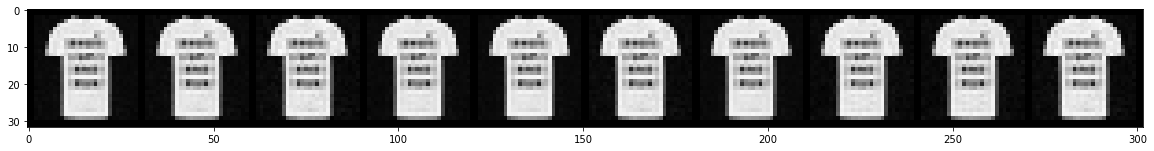

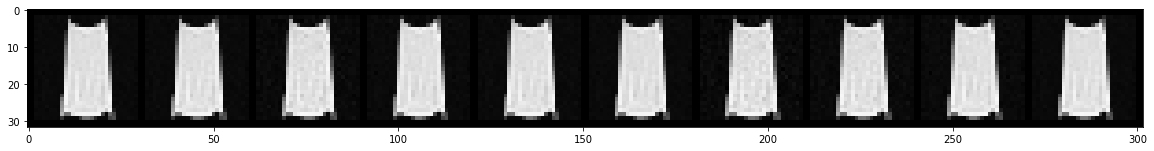

In [175]:
grid = torchvision.utils.make_grid(m_sampling_21.perturbs[0][0:10], nrow=10)
plt.figure(figsize=(20, 3))
plt.imshow(np.transpose(grid, (1, 2, 0)))

grid = torchvision.utils.make_grid(m_sampling_21.perturbs[1][0:10], nrow=10)
plt.figure(figsize=(20, 3))
plt.imshow(np.transpose(grid, (1, 2, 0)))

# grid = torchvision.utils.make_grid(m_sampling_31.perturbs[0][0:10], nrow=10)
# plt.figure(figsize=(20, 3))
# plt.imshow(np.transpose(grid, (1, 2, 0)))

# grid = torchvision.utils.make_grid(m_sampling_32.perturbs[0][0:10], nrow=10)
# plt.figure(figsize=(20, 3))
# plt.imshow(np.transpose(grid, (1, 2, 0)))

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def get_discriminator_performance(X,y,n_estimators = 100, test_ratio = 0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    the_rf = RandomForestClassifier(n_estimators=n_estimators).fit(X_train, y_train)
    y_pred = the_rf.predict(X_test)
    the_rf_result = (y_pred == y_test).sum()
    return the_rf, the_rf_result/y_test.shape[0], X_train.shape[0]

In [103]:
m_sampling_21.train_multiplier = 100
m_sampling_21.std_train = 0.001
m_sampling_21.train_pivot(no_pivots_per_label = 5, shuffle = True)

In [284]:
X_in = m_sampling_21.pivots.numpy()
X_per = np.expand_dims(np.vstack([perturbs[0] for perturbs in m_sampling_21.perturbs]), axis = 1)
# X_in_dup = np.repeat(X_in, 100, axis = 0)

X_discriminator = np.vstack((X_in, X_test_plane))
y_discriminator = np.concatenate((np.zeros(X_in.shape[0]), np.ones(X_test_plane.shape[0])))

the_rf, test_acc, no_trains = get_discriminator_performance(m_sampling_21.to_1d(X_discriminator),y_discriminator,n_estimators = 1, test_ratio = 0.1)
print(test_acc, no_trains)

1.0 90


In [121]:
# m_sampling_32.train_multiplier = 100
# m_sampling_32.std_train = 0.001
# m_sampling_32.train_pivot(no_pivots_per_label = 2, shuffle = True)

In [191]:
m_sampling_21.plane_noise[1].shape

(100, 1, 28, 28)

In [194]:
X_test_plane = np.zeros_like(X_test_ori)
X_test_ortho = np.zeros_like(X_test_ori)
for i in range(X_test_plane.shape[0]):
    X_test_plane[i] = m_sampling_21.pivots[i] + m_sampling_21.plane_noise[i][0]
    X_test_ortho[i] = m_sampling_21.pivots[i] + m_sampling_21.ortho_noise[i][0]

In [195]:
X_test_ori = m_sampling_21.pivots.numpy()
# X_test_per = np.expand_dims(np.vstack([perturbs[1] + sample for sample, perturbs in zip(list(m_sampling_21.pivots), m_sampling_21.plane_noise)]), axis = 1)

print(the_rf.predict(m_sampling_21.to_1d(X_in)))
print(the_rf.predict(m_sampling_21.to_1d(X_test_ori)))
print(the_rf.predict(m_sampling_21.to_1d(X_test_plane)))
print(the_rf.predict(m_sampling_21.to_1d(X_test_ortho)))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1.]


In [154]:
diff = torch.abs(torch.tensor(X_test_per) - X_test_ori)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


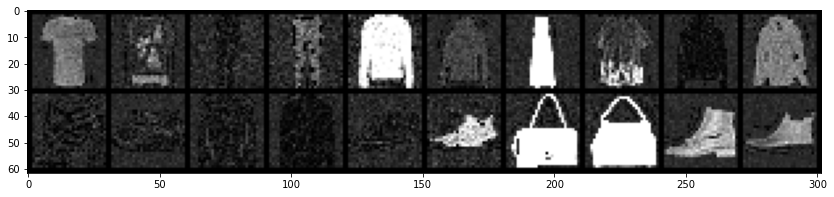

In [157]:
grid = torchvision.utils.make_grid(diff/torch.max(diff)*4, nrow=10)
plt.figure(figsize=(20, 3))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [56]:
ex_img = images[6]
# ex_G = man_sampling.get_G(ex_img)
# ex_per, ex_d = man_sampling.get_x_noise_low_plane(ex_img,ex_G, 200, 0.2)

In [57]:
X_ori, X_per, X_dist = man_sampling.get_hyperplane_perturbations(ex_img, no_samples = 200, std_x = 0.1)

In [58]:
# torch.var(X_ori - X_per)
X_per.shape

(5200, 1, 28, 28)

In [59]:
# offset = 1200
# grid = torchvision.utils.make_grid(torch.tensor(X_per)[offset:offset+10], nrow=10)
# plt.figure(figsize=(30, 3))
# plt.imshow(np.transpose(grid, (1, 2, 0)))

# grid = torchvision.utils.make_grid(torch.tensor(X_in_dup)[offset:offset+10], nrow=10)
# plt.figure(figsize=(30, 3))
# plt.imshow(np.transpose(grid, (1, 2, 0)))

In [60]:
man_sampling.pivots.shape

torch.Size([50, 1, 28, 28])

In [61]:
X_per = man_sampling.pivots.clone()
X_ori = torch.cat(X_per.shape[0]*[ex_img.unsqueeze(0)])

In [62]:
    def get_pivots_perturbations(self, x):
        X_pivot = self.pivots.clone()
        X_ori = torch.cat(X_per.shape[0]*[x.unsqueeze(0)])
        X_pivot_low = self.pivots_low.copy()
        X_low = np.repeat(self.transform(x.unsqueeze(0)), X_pivot.shape[0], axis = 0)
        perturb_d = np.linalg.norm(X_pivot_low - X_low, axis=1)
        
#         perturb_d = []
#         for pivot in range(X_pivot.shape[0]):
#             perturb_d.append(np.linalg.norm(X_low[pivot] - x_low, axis=1))
            
#         perturb_d.append(x_d)
#         perturbations = self.perturbs.copy()
#         perturbations.append(x_per)
#         perturbations_np = np.vstack(perturbations)
#         perturb_d_np = np.concatenate(perturb_d)
#         x_dup = torch.cat(perturbations_np.shape[0]*[x.unsqueeze(0)])
        return X_ori, X_pivot, perturb_d

In [63]:
X_pivot = man_sampling.pivots.clone()
X_ori = torch.cat(X_per.shape[0]*[ex_img.unsqueeze(0)])
X_pivot_low = man_sampling.pivots_low.copy()
X_low = np.repeat(man_sampling.transform(ex_img.unsqueeze(0)), X_pivot.shape[0], axis = 0)
perturb_d = np.linalg.norm(X_pivot_low - X_low, axis=1)

In [64]:
perturb_h = np.linalg.norm(X_pivot.reshape(X_pivot.shape[0],-1) - X_ori.reshape(X_pivot.shape[0],-1), axis=1)

In [75]:
X_per = X_pivot
X_dist = perturb_d

In [76]:
perturb_d

array([13.101734 , 15.88857  , 15.73853  , 14.347348 , 15.7072315,
       11.90377  , 12.857199 , 12.635373 , 11.686715 , 11.158395 ,
       11.003451 , 12.3460655, 11.290656 , 12.17349  , 12.303188 ,
       12.107919 , 10.114446 , 11.8983755, 12.188822 , 11.9701395,
       11.857755 , 12.189311 , 11.585538 , 11.899953 , 12.693662 ,
        2.486684 ,  6.7955914,  5.2222295,  5.7367215,  5.846172 ,
       11.8967285, 12.286018 ,  8.473142 , 13.040975 , 12.021282 ,
        0.6127601,  3.1137736,  1.6573237,  1.6985395,  1.8236986,
        8.2427225, 10.684598 , 10.608847 , 10.780861 ,  9.606113 ,
        7.965782 ,  7.8163743,  6.061542 ,  6.2313805,  7.69863  ],
      dtype=float32)

In [77]:
perturb_h

array([12.737254 , 17.453926 , 15.43355  , 15.433089 , 15.68724  ,
       10.9398775, 13.314447 , 12.762081 , 11.102259 ,  9.95319  ,
       14.912305 , 12.663812 , 13.997031 , 11.283676 , 15.11977  ,
       12.730155 , 11.695116 , 13.569127 , 14.520914 , 12.646486 ,
       13.022743 , 13.396825 , 14.266014 , 13.812839 , 16.62783  ,
        9.014765 , 12.15308  ,  9.232028 , 11.361262 , 10.857724 ,
       11.555489 , 15.901884 , 14.180898 , 10.273097 , 16.246592 ,
        5.189034 ,  7.7070737,  6.741284 ,  7.2915363,  6.0052896,
       11.698897 , 11.003404 , 14.635313 , 12.654669 , 14.021385 ,
       11.944742 , 13.609636 , 11.079209 , 11.245085 , 12.533899 ],
      dtype=float32)

In [78]:
from sklearn import linear_model

def similarity_kernel(d,kernel_width = 1):
    return np.exp(- (d**2) / (kernel_width**2))

/tmp/ipykernel_255746/1024620396.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturb_outputs = model(torch.tensor(X_per).float().to(device))
/tmp/ipykernel_255746/1024620396.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_perturb = np.abs(torch.tensor(X_per) - X_ori)
/tmp/ipykernel_255746/1024620396.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturb_outputs = model(torch.tensor(X_per).float().to(device))
/tmp/ipykernel_255746/1024620396.py:15: UserWarning: To copy construct from a tensor, it is recommended to us

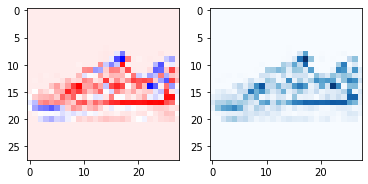

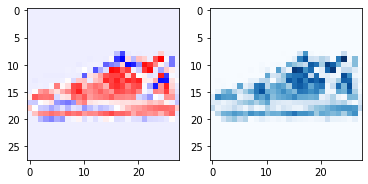

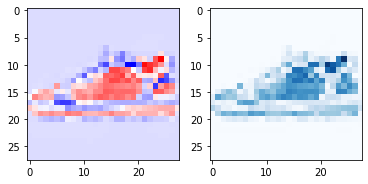

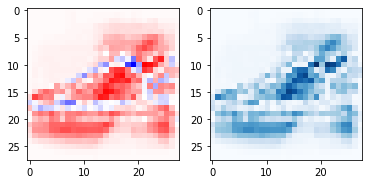

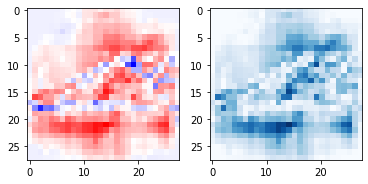

In [79]:
width_range = [0.1, 0.2, 0.4, 1.0, 2, 4, 10]

for k_width in [0.4, 1.0, 2, 4, 10]:

    X_sim = np.asarray([similarity_kernel(d, kernel_width = k_width) for d in list(X_dist)])

    original_output = model(ex_img.unsqueeze(0).to(device))
    original_prediction = torch.max(original_output, 1)[1]
    perturb_outputs = model(torch.tensor(X_per).float().to(device))
    probs = nn.functional.softmax(perturb_outputs, dim = 1)
    perturb_targets = probs[:,original_prediction.item()].cpu().detach().numpy()

    clf = linear_model.Ridge(alpha = 100)
    # clf = linear_model.Lasso(alpha = 0.00001)
    true_perturb = np.abs(torch.tensor(X_per) - X_ori)
    no_samples, channels, rows, cols = true_perturb.shape
    clf.fit(true_perturb.reshape(no_samples, channels*rows*cols), perturb_targets, sample_weight=X_sim)
    explanations = clf.coef_.reshape(rows, cols)
    plt.figure(figsize = (6,3))
    plt.subplot(1, 2, 1)
    plt.imshow(-explanations, cmap=plt.get_cmap('bwr'))
    plt.subplot(1, 2, 2)
    plt.imshow(np.abs(explanations), cmap=plt.get_cmap('Blues'))

In [82]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split

# def get_discriminator_performance(X,y,n_estimators = 100, test_ratio = 0.5):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
#     the_rf = RandomForestClassifier(n_estimators=n_estimators).fit(X_train, y_train)
#     y_pred = the_rf.predict(X_test)
#     the_rf_result = (y_pred == y_test).sum()
#     return the_rf, the_rf_result/y_test.shape[0], X_train.shape[0]

In [86]:
X_in = man_sampling.pivots.numpy()
X_in_dup = np.repeat(X_in, 10, axis = 0)

X_discriminator = np.vstack((X_in_dup, X_per))
y_discriminator = np.concatenate((np.zeros(X_in_dup.shape[0]), np.ones(X_per.shape[0])))

In [87]:
the_rf, test_acc, no_trains = get_discriminator_performance(man_sampling.to_1d(X_discriminator),y_discriminator,n_estimators = 1, test_ratio = 0.995)
print(test_acc, no_trains)

0.9087591240875912 2


In [85]:
X_discriminator.shape

(5050, 1, 28, 28)

In [376]:
X_per_ = X_per.copy()
X_per_[np.where(X_in == 0)] = 0

np.sum(the_rf.predict(man_sampling.to_1d(X_per_)))/X_per_.shape[0]

0.9846153846153847

In [310]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

In [313]:
x = band_limited_noise(200, 2000, 44100, 44100)

In [314]:
x

array([0.00295049, 0.00333457, 0.00365295, ..., 0.00157851, 0.00205424,
       0.00251769])